In [1]:
!source activate python3
!pip3 install pymongo
!pip3 install dnspython
!pip3 install pymongo[srv]
!pip3 install xgboost
!source deactivate

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


Feeds_Data:  (5210, 22)


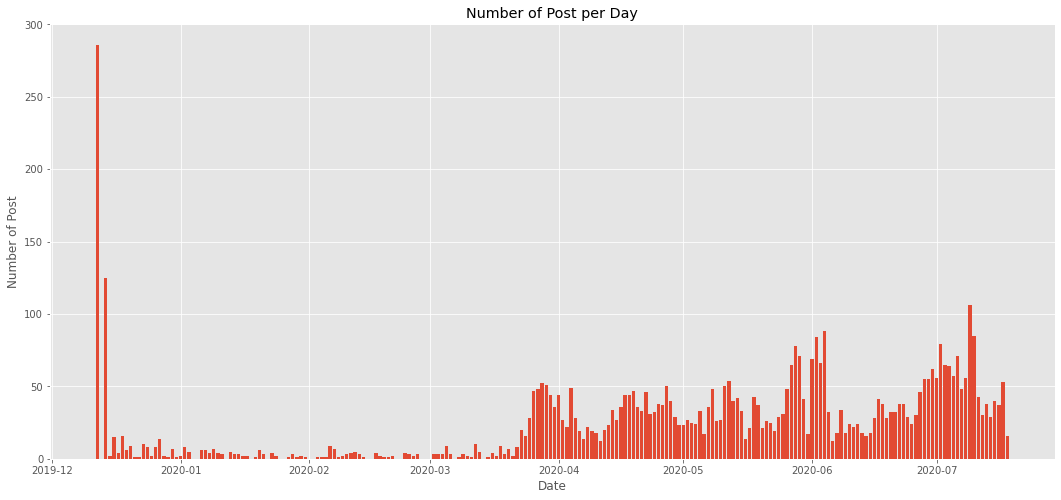

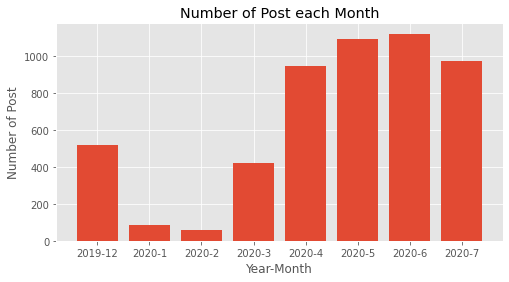

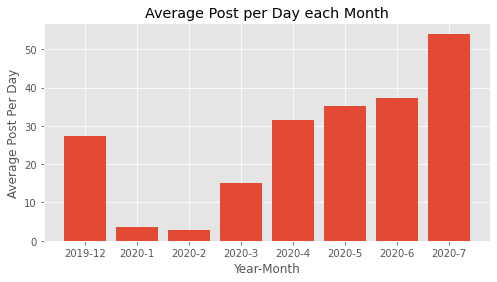

Unique hashtag ID: 8663
Unique hashtag: 7760
Unique authors: 3493
Primary Hashtags: 12
Data Row Count: 22110
unique feed ID: 5210
unique feed: 4928
unique feed author ID: 2767
unique tag ID: 3594
unique hashtags: 3256
unique hashtag author ID: 703
Average Hashtags in a Post:  4.243761996161228


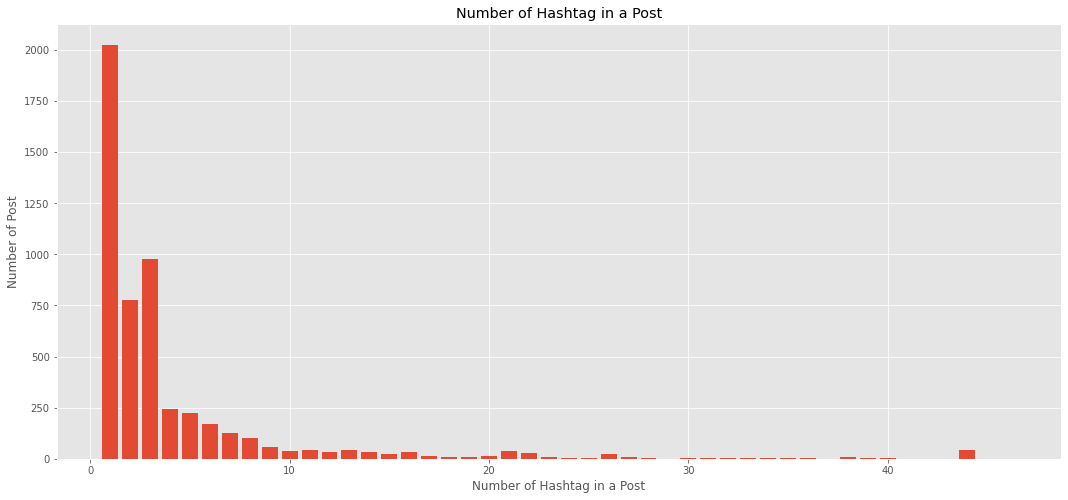

Average Hashtags in a Post:  4.243761996161228


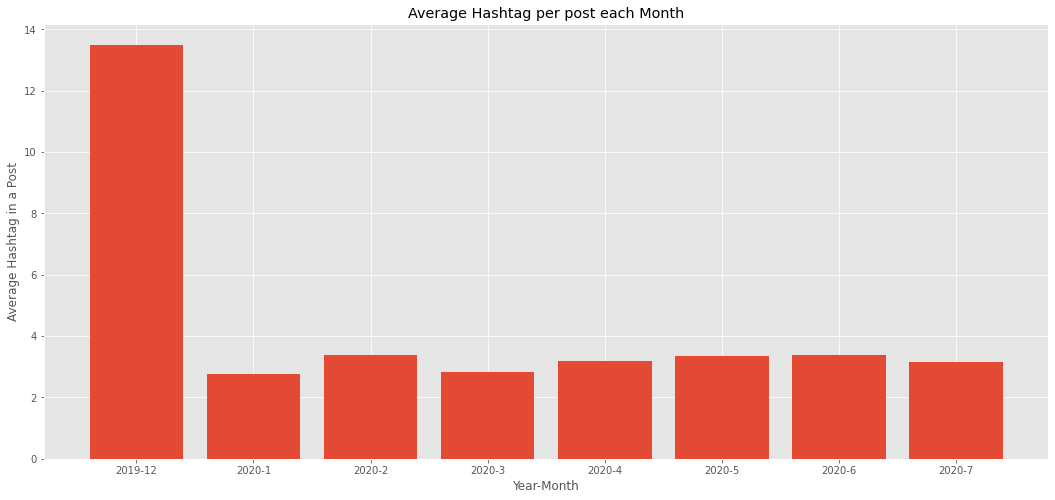

In [2]:
from Data_Creation_for_Tag_Classification import *

In [3]:
import nltk
nltk.download(['punkt', 'stopwords'])

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import pickle

In [5]:
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split

import xgboost

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from tensorflow import keras

Using TensorFlow backend.


In [6]:
#feed_hashtag = pd.read_csv(os.getcwd() + '/Datasets/feed_hashtag_long.csv')
#feed_hashtag['createdAt'] = pd.to_datetime(feed_hashtag['createdAt'])
#print(feed_hashtag.shape)
#feed_hashtag.head(1)

In [7]:
feed_hashtag = feed_hashtag[feed_hashtag['isPrimary'] == True]
feed_hashtag = feed_hashtag[~feed_hashtag['text'].isna()]
print("Data Size:", feed_hashtag.shape[0])
print("Unique Content:", feed_hashtag['contentId'].nunique())
print("Unique tags:", feed_hashtag['hashtag'].nunique())

Data Size: 8512
Unique Content: 5038
Unique tags: 12


In [8]:
feed_hashtag['createDate'] = feed_hashtag['createdAt'].dt.date
feed_hashtag.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate
0,5df454f37e4ea600161b8e2e,5df454297e4ea600161b8e25,2019-12-14 03:20:19.029,5df3940fb2694d0016bdb722,Hi I am Shreshtha. I have been baking for the ...,QUESTION,2019-12-14,12,2019,2019-12,5df3940fb2694d0016bdb722,5df38de0b2694d0016bdb71f,marketingQueries,True,True,2019-12-14


In [9]:
#feed_hashtag.groupby(['createDate']).agg({'contentId':'nunique', 'tagIds':'count'})

In [10]:
feed_hashtag = feed_hashtag.sort_values(['contentId'])

In [11]:
#feed_hashtag.groupby(['contentId'])['hashtag'].count().reset_index().sort_values(['hashtag'], ascending = False).head()

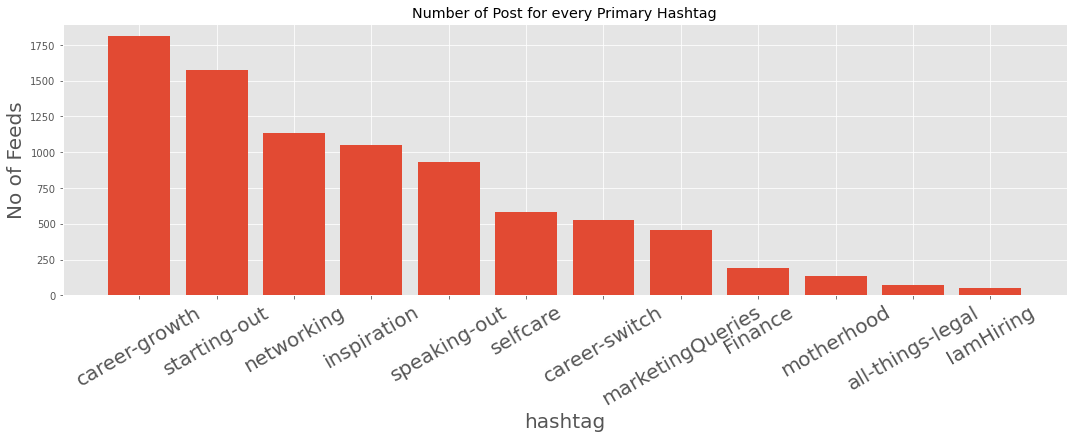

In [12]:
hashtag_class_ct = feed_hashtag.groupby(['hashtag'])['contentId'].agg([('row_count','count'), ('content_count','nunique')]).reset_index()
hashtag_class_ct = hashtag_class_ct.sort_values(['content_count'], ascending=False)
hashtag_class_ct
f, ax = plt.subplots(figsize=(18,5))
plt.bar(hashtag_class_ct['hashtag'], hashtag_class_ct['content_count'])
plt.xlabel('hashtag', fontsize=20)
plt.ylabel('No of Feeds', fontsize=20)
plt.xticks(hashtag_class_ct['hashtag'], fontsize=20, rotation=30)
plt.title('hashtag counts')

plt.title("Number of Post for every Primary Hashtag")
plt.savefig(os.getcwd()+'/Charts/Total_Post_Per_Primary_Hashtag.png')

plt.show()
plt.close()

In [13]:
feed_hashtag_rollup = feed_hashtag.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(feed_hashtag_rollup.shape)
feed_hashtag_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(5038, 9)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,hashtag_count,hashtag_list
1943,5ea903a51081fc002f901eaf,5ea90095cc13d50046a192fe,2020-04-29 04:33:41.016,"Hi, I am teaching spanish language, If anyone ...",POST,True,True,5,"starting-out,selfcare,inspiration,career-switc..."
3405,5ee2451f92551200283cc28a,5e809291b0854d0031972a19,2020-06-11 14:52:15.190,🌸B.E Y.O.U 🌸 * This is absolutely worth it wh...,POST,True,True,4,"inspiration,selfcare,starting-out,speaking-out"


In [14]:
train_test_cutoff = pd.to_datetime(feed_hashtag['createDate'].max() - timedelta(10))
train_test_cutoff

Timestamp('2020-07-08 00:00:00')

In [15]:
train = feed_hashtag[feed_hashtag['createdAt'] <= train_test_cutoff].copy()
print("train data:", train.shape[0])
test = feed_hashtag[feed_hashtag['createdAt'] > train_test_cutoff].copy()
print("test data:", test.shape[0])

train data: 7572
test data: 940


# Text Cleansing

In [16]:
def del_stop(sent, stop_word_list):
    return [term for term in sent if term not in stop_word_list]

porter = PorterStemmer()
def stem_tokens(token_list):
    token_stem = [porter.stem(term) for term in token_list]
    return(token_stem)

def get_clean_text(txt):
    feed_token = [word_tokenize(sent.lower()) for sent in txt]
    
    stop_punct = list(punctuation)
    stop_nltk = stopwords.words("english")
    stop_updated = stop_nltk + stop_punct
    
    feed_token_clean = [del_stop(sent, stop_updated) for sent in feed_token]
    feed_token_stemmed = [stem_tokens(tk) for tk in feed_token_clean]
    
    clean_text = [" ".join(sent) for sent in feed_token_clean]
    return(clean_text)

In [17]:
train['text_clean'] = get_clean_text(train.text)
train.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate,text_clean
0,5df454f37e4ea600161b8e2e,5df454297e4ea600161b8e25,2019-12-14 03:20:19.029,5df3940fb2694d0016bdb722,Hi I am Shreshtha. I have been baking for the ...,QUESTION,2019-12-14,12,2019,2019-12,5df3940fb2694d0016bdb722,5df38de0b2694d0016bdb71f,marketingQueries,True,True,2019-12-14,hi shreshtha baking last 5 years brand associa...


In [18]:
test['text_clean'] = get_clean_text(test.text)
test.head(1)

,contentId,authorId_content,createdAt,tagIds,text,type,dt,mnth,yr,yr_mnth,hashtagId,authorId_hashtag,hashtag,isActive,isPrimary,createDate,text_clean
20636,5f053b56f824310022082bf3,5f0538ca748c8600249cd63d,2020-07-08 03:19:50.689,5df39412b2694d0016bdb72a,Hello ladies. I am a marketer and have been wa...,QUESTION,2020-07-08,7,2020,2020-7,5df39412b2694d0016bdb72a,5df38de0b2694d0016bdb71f,career-switch,True,True,2020-07-08,hello ladies marketer wanting make switch data...


In [19]:
train_rollup = train.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary', 'text_clean'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
train_rollup.shape

(4505, 10)

In [20]:
train_df_rollup, validation_rollup = model_selection.train_test_split(train_rollup, test_size=0.20)
print(train_df_rollup.shape, validation_rollup.shape)
train_df = train[train['contentId'].isin(train_df_rollup['contentId'])]
validation = train[train['contentId'].isin(validation_rollup['contentId'])]
print(train_df.shape)
print(validation.shape)

(3604, 10) (901, 10)
(6056, 17)
(1516, 17)


In [21]:
test_rollup = test.groupby(['contentId', 'authorId_content', 'createdAt', 'text', 'type', 'isActive', 'isPrimary', 'text_clean'])['hashtag'].agg([('hashtag_count','count'), ('hashtag_list', ','.join)]).reset_index()
print(test_rollup.shape)
test_rollup.sort_values(['hashtag_count'],ascending=False).head(2)

(533, 10)


,contentId,authorId_content,createdAt,text,type,isActive,isPrimary,text_clean,hashtag_count,hashtag_list
451,5f105c921499b90023fd3a9a,5eecf8e53657f20022e94c7a,2020-07-16 13:56:34.237,Rest Chair with Lighting Practice.. 3ds Max Wo...,POST,True,True,rest chair lighting practice.. 3ds max work 3d...,3,"starting-out,inspiration,career-growth"
219,5f0874983fbf9700246b488c,5e9d8a8afe4a680046e1250b,2020-07-10 14:00:56.461,"Hello fellow Kool Kanyas, We are looking for...",POST,True,True,hello fellow kool kanyas looking partners join...,3,"career-growth,starting-out,networking"


In [22]:
train_x = train_df['text_clean']
train_y = train_df['hashtag']
valid_x = validation_rollup['text_clean']
valid_y = validation_rollup['hashtag_list']
test_x = test_rollup['text_clean']
test_y = test_rollup['hashtag_list']

In [23]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_enc = encoder.fit_transform(train_y)

In [24]:
mapping = pd.DataFrame({'hashtag':train_y, 'hashtag_encoding':train_y_enc})
mapping = mapping.drop_duplicates()
mapping.sort_values(['hashtag_encoding'])

,hashtag,hashtag_encoding
2,Finance,0
17782,IamHiring,1
71,all-things-legal,2
1,career-growth,3
8,career-switch,4
6,inspiration,5
0,marketingQueries,6
2306,motherhood,7
58,networking,8
82,selfcare,9


# Feature Creation

In [25]:
text_for_feature = train['text_clean']

In [26]:
def feature_creation_func(feature_type):
    if(feature_type == 'Count Vectorizer'):
        # create a count vectorizer object 
        count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
        count_vect.fit(text_for_feature)
        # transform the training and validation data using count vectorizer object
        xtrain_feature =  count_vect.transform(train_x)
        xvalid_feature =  count_vect.transform(valid_x)
        xtest_feature = count_vect.transform(test_x)
    
    if(feature_type == 'Word TFIDF'):
        # word level tf-idf
        tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
        tfidf_vect.fit(text_for_feature)
        xtrain_feature =  tfidf_vect.transform(train_x)
        xvalid_feature =  tfidf_vect.transform(valid_x)
        xtest_feature = tfidf_vect.transform(test_x)
        
    if(feature_type == 'N-gram TFIDF'):
        # ngram level tf-idf 
        tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
        tfidf_vect_ngram.fit(text_for_feature)
        xtrain_feature =  tfidf_vect_ngram.transform(train_x)
        xvalid_feature =  tfidf_vect_ngram.transform(valid_x)
        xtest_feature =  tfidf_vect_ngram.transform(test_x)
        
    if(feature_type == 'Character TFIDF'):
        # characters level tf-idf
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
        tfidf_vect_ngram_chars.fit(text_for_feature)
        xtrain_feature =  tfidf_vect_ngram_chars.transform(train_x) 
        xvalid_feature =  tfidf_vect_ngram_chars.transform(valid_x) 
        xtest_feature =  tfidf_vect_ngram_chars.transform(test_x)
        
    return(xtrain_feature, xvalid_feature, xtest_feature)

In [27]:
FEATURE_TYPE = 'Word TFIDF'
xtrain_var, xvalid_var, xtest_var = feature_creation_func(FEATURE_TYPE)

# Model Building

### Shallow Neural Networks

In [28]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(1000, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(mapping.shape[0], activation="softmax")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return(classifier)

In [29]:
#train_y_onehot_enc = pd.get_dummies(train_y_enc)
#classifier = create_model_architecture(xtrain_var.shape[1])
#classifier.fit(xtrain_var, train_y_onehot_enc, epochs=5)
#prob_predictions = classifier.predict(xvalid_var)

### All Models

In [30]:
def build_model(model_name):
    #Naive Bayes Model
    if(model_name == 'Naive Bayes'):
        model = naive_bayes.MultinomialNB()
        model.fit(xtrain_var, train_y_enc)
    
    #SVM Model
    if(model_name == 'SVM'):
        model = svm.SVC(probability=True)
        model.fit(xtrain_var, train_y_enc)
    
    #Random Forest Model
    if(model_name == 'Random Forest'):
        model = ensemble.RandomForestClassifier()
        model.fit(xtrain_var, train_y_enc)
    
    #XGBoost Model
    if(model_name == 'XGBoost'):
        model = xgboost.XGBClassifier()
        model.fit(xtrain_var, train_y_enc)
    
    #Shallow Neural Networks Model
    if(model_name == 'Shallow Neural Networks'):
        train_y_onehot_enc = pd.get_dummies(train_y_enc)
        
        model = create_model_architecture(xtrain_var.shape[1])
        model.fit(xtrain_var, train_y_onehot_enc, epochs=5)
    
    return(model)

In [31]:
MODEL_NAME = 'Shallow Neural Networks'
classifier = build_model(MODEL_NAME)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





6056/6056 [==============================] - 12s 2ms/step - loss: 0.2482
Epoch 2/5
6056/6056 [==============================] - 11s 2ms/step - loss: 0.2140
Epoch 3/5
6056/6056 [==============================] - 11s 2ms/step - loss: 0.1915
Epoch 4/5
6056/6056 [==============================] - 11s 2ms/step - loss: 0.1751
Epoch 5/5
6056/6056 [==============================] - 11s 2ms/step - loss: 0.1638


In [32]:
weight = classifier.get_weights()
pklfile= os.getcwd() + '/Model_Output/shallow_neural_network_classifier.pkl'

try:
    fpkl= open(pklfile, 'wb')    #Python 3     
    pickle.dump(classifier, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
except:
    fpkl= open(pklfile, 'w')    #Python 2      
    pickle.dump(classifier, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()

In [33]:
with open(os.getcwd() + '/Model_Output/shallow_neural_network_classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)

### Deep Neural Networks - CNN

In [35]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((5000,1))

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(input_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(mapping.shape[0], activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

In [46]:
classifier = create_cnn()
classifier.fit(xtrain_var, train_y_onehot_enc)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


NameError: name 'train_y_onehot_enc' is not defined

# Prediction for Accuracy

In [34]:
def prediction_accuracy_func(model_name, x_var, measurement_df):
    if(model_name == 'Shallow Neural Networks'):
        prob_predictions = classifier.predict(x_var)
    else:
        prob_predictions = classifier.predict_proba(x_var)
        
    print("Evaluating: ", model_name)
    prob_prediction_df = pd.DataFrame(prob_predictions)
    print("prob_prediction_df", prob_prediction_df.shape)
    prob_prediction_df['contentId'] = list(measurement_df['contentId'])
    
    prob_prediction_df_long = pd.melt(prob_prediction_df, id_vars='contentId', value_vars=range(mapping.shape[0]))
    prob_prediction_df_long.columns = ['contentId', 'hashtag_encoding', 'predicted_prob']
    prob_prediction_df_long['hashtag_rank'] = prob_prediction_df_long.groupby(['contentId'])['predicted_prob'].rank(ascending=False, method = 'first')
    prob_prediction_df_long = prob_prediction_df_long.sort_values(['contentId', 'hashtag_rank'])
    prob_prediction_df_long = pd.merge(prob_prediction_df_long, mapping, how = 'left', on = 'hashtag_encoding')
    prob_prediction_df_long['pred_rank'] = 'pred_rank_' + prob_prediction_df_long['hashtag_rank'].astype(int).map(str)
    prob_prediction_df_long = prob_prediction_df_long.sort_values(['contentId', 'hashtag_rank'])
    print("prob_prediction_df_long", prob_prediction_df_long.shape)
    
    prob_prediction_df_wide = prob_prediction_df_long.pivot_table(index = ['contentId'], columns = 'pred_rank', values = ['hashtag'], aggfunc=lambda x: ''.join(x))
    prob_prediction_df_wide = prob_prediction_df_wide.reset_index()
    prob_prediction_df_wide.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in prob_prediction_df_wide.columns]
    print("prob_prediction_df_wide", prob_prediction_df_wide.shape)
    
    prediction_results = pd.merge(measurement_df[['contentId', 'text', 'hashtag_list', 'hashtag_count']], prob_prediction_df_wide, how = 'right', on='contentId', sort=False, copy=True)
    print("prediction_results", prediction_results.shape)
    
    print("")
    
    print("Exact Match 1st Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_1']))
    print("Exact Match 2nd Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_2']))
    print("Exact Match 3rd Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_3']))
    print("Exact Match 4th Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_4']))
    print("Exact Match 5th Prediction:", sum(prediction_results['hashtag_list'] == prediction_results['hashtag_pred_rank_5']))
    
    h_list = prediction_results['hashtag_list'].str.split(',')

    top_3_pred = prediction_results[['hashtag_pred_rank_1', 'hashtag_pred_rank_2', 'hashtag_pred_rank_3']].values.tolist()
    
    prediction_results['matching_hashtag_ct'] = [len(set(a) & set(b)) for a,b in zip(h_list, top_3_pred)]
    prediction_results['matching_percent'] = (prediction_results['matching_hashtag_ct']/prediction_results['hashtag_count'])*100
    
    pred_summary = prediction_results.groupby(['matching_percent'])['contentId'].count().reset_index()
    pred_summary['content_proportion'] = (pred_summary['contentId']/sum(pred_summary['contentId']))*100
    pred_summary.sort_values(['matching_percent'], ascending=False)
    
    pred_summary_by_hash_ct = prediction_results.groupby(['matching_percent', 'hashtag_count'])['contentId'].count().reset_index()
    pred_summary_by_hash_ct.sort_values(['hashtag_count', 'matching_percent'], ascending=False)
    
    return(pred_summary, pred_summary_by_hash_ct, prediction_results)


In [35]:
pred_summary_valid, pred_summary_by_hash_ct_valid, prediction_results_valid = prediction_accuracy_func(MODEL_NAME, xvalid_var, validation_rollup)
pred_summary_valid

Evaluating:  Shallow Neural Networks
prob_prediction_df (901, 12)
prob_prediction_df_long (10812, 6)
prob_prediction_df_wide (901, 13)
prediction_results (901, 16)

Exact Match 1st Prediction: 205
Exact Match 2nd Prediction: 122
Exact Match 3rd Prediction: 68
Exact Match 4th Prediction: 47
Exact Match 5th Prediction: 25


,matching_percent,contentId,content_proportion
0,0.000000,142,15.760266
1,33.333333,45,4.994451
2,50.000000,60,6.659267
3,66.666667,120,13.318535
4,100.000000,534,59.267481


In [36]:
pred_summary_by_hash_ct_valid

,matching_percent,hashtag_count,contentId
0,0.000000,1,122
1,0.000000,2,14
2,0.000000,3,6
3,33.333333,3,45
4,50.000000,2,59
5,50.000000,4,1
6,66.666667,3,120
7,100.000000,1,395
8,100.000000,2,81
9,100.000000,3,58


In [37]:
prediction_results_valid.head()

,contentId,text,hashtag_list,hashtag_count,hashtag_pred_rank_1,hashtag_pred_rank_10,hashtag_pred_rank_11,hashtag_pred_rank_12,hashtag_pred_rank_2,hashtag_pred_rank_3,hashtag_pred_rank_4,hashtag_pred_rank_5,hashtag_pred_rank_6,hashtag_pred_rank_7,hashtag_pred_rank_8,hashtag_pred_rank_9,matching_hashtag_ct,matching_percent
0,5ecf3ed2430327002815b97f,,speaking-out,1,speaking-out,career-switch,all-things-legal,IamHiring,inspiration,selfcare,career-growth,starting-out,networking,marketingQueries,motherhood,Finance,1,100.000000
1,5e81a2a61a291b002251c10c,Hi I am looking for an Opportunity into HR Ope...,career-switch,1,career-switch,all-things-legal,IamHiring,motherhood,career-growth,starting-out,networking,Finance,speaking-out,marketingQueries,inspiration,selfcare,1,100.000000
2,5eb2f78ab427d9003de7a555,Hi. I have recently joined into B2B sales. Can...,"speaking-out,marketingQueries,inspiration",3,speaking-out,Finance,motherhood,IamHiring,inspiration,networking,career-growth,starting-out,selfcare,marketingQueries,career-switch,all-things-legal,2,66.666667
3,5df45c6e7e4ea600161b8efb,Hey. I’m Shefali. I want to get into interior ...,career-growth,1,starting-out,all-things-legal,motherhood,IamHiring,career-growth,career-switch,networking,inspiration,speaking-out,Finance,selfcare,marketingQueries,1,100.000000
4,5e9c5a025764a70044106341,"I am graphic designer, I am looking for some f...",starting-out,1,career-growth,motherhood,all-things-legal,IamHiring,starting-out,networking,marketingQueries,Finance,speaking-out,inspiration,selfcare,career-switch,1,100.000000


In [38]:
pred_summary_test, pred_summary_by_hash_ct_test, prediction_results_test = prediction_accuracy_func(MODEL_NAME, xtest_var, test_rollup)
pred_summary_test

Evaluating:  Shallow Neural Networks
prob_prediction_df (533, 12)
prob_prediction_df_long (6396, 6)
prob_prediction_df_wide (533, 13)
prediction_results (533, 16)

Exact Match 1st Prediction: 77
Exact Match 2nd Prediction: 63
Exact Match 3rd Prediction: 42
Exact Match 4th Prediction: 38
Exact Match 5th Prediction: 18


,matching_percent,contentId,content_proportion
0,0.000000,113,21.200750
1,33.333333,41,7.692308
2,50.000000,46,8.630394
3,66.666667,79,14.821764
4,100.000000,254,47.654784


In [39]:
pred_summary_by_hash_ct_test

,matching_percent,hashtag_count,contentId
0,0.000000,1,95
1,0.000000,2,12
2,0.000000,3,6
3,33.333333,3,41
4,50.000000,2,46
5,66.666667,3,79
6,100.000000,1,182
7,100.000000,2,47
8,100.000000,3,25


In [40]:
prediction_results_test[prediction_results_test['matching_percent'] == 75.000000]

,contentId,text,hashtag_list,hashtag_count,hashtag_pred_rank_1,hashtag_pred_rank_10,hashtag_pred_rank_11,hashtag_pred_rank_12,hashtag_pred_rank_2,hashtag_pred_rank_3,hashtag_pred_rank_4,hashtag_pred_rank_5,hashtag_pred_rank_6,hashtag_pred_rank_7,hashtag_pred_rank_8,hashtag_pred_rank_9,matching_hashtag_ct,matching_percent


# Running All Combinations

In [41]:
feature_list = ['Count Vectorizer', 'Word TFIDF', 'N-gram TFIDF', 'Character TFIDF']
model_list = ['Naive Bayes', 'SVM', 'Random Forest', 'XGBoost', 'Shallow Neural Networks']

In [42]:
summary_valid = pd.DataFrame(columns = ['feature_type', 'model_type', 'match_ct', 'non_match_ct', 'match_proportion', 'non_match_proportion'])
summary_test = pd.DataFrame(columns = ['feature_type', 'model_type', 'match_ct', 'non_match_ct', 'match_proportion', 'non_match_proportion'])
for feature in feature_list:
    FEATURE_TYPE = feature
    xtrain_var, xvalid_var, xtest_var = feature_creation_func(FEATURE_TYPE)
    
    for mod_type in model_list:
        print("==========================================================================================>")
        print("Running ", mod_type, "on ", feature)
                
        MODEL_NAME = mod_type
        classifier = build_model(MODEL_NAME)
        
        #Measuring Validation Data Accuracy
        pred_summary_valid, pred_summary_by_hash_ct_valid, prediction_results_valid = prediction_accuracy_func(MODEL_NAME, xvalid_var, validation_rollup)
        
        pred_summary = pd.DataFrame(index=[0], columns = summary_valid.columns)
        pred_summary['feature_type'] = feature
        pred_summary['model_type'] = mod_type
        pred_summary['match_ct'] = pred_summary_valid[pred_summary_valid['matching_percent']>0.000000]['contentId'].sum()
        pred_summary['non_match_ct'] = pred_summary_valid[pred_summary_valid['matching_percent']==0.000000]['contentId'].sum()
        pred_summary['match_proportion'] = pred_summary_valid[pred_summary_valid['matching_percent']>0.000000]['content_proportion'].sum()
        pred_summary['non_match_proportion'] = pred_summary_valid[pred_summary_valid['matching_percent']==0.000000]['content_proportion'].sum()
        
        summary_valid = summary_valid.append(pred_summary)
        del(pred_summary)
        
        #Measuring Test Data Accuracy
        pred_summary_test, pred_summary_by_hash_ct_test, prediction_results_test = prediction_accuracy_func(MODEL_NAME, xtest_var, test_rollup)
        
        pred_summary = pd.DataFrame(index=[0], columns = summary_test.columns)
        pred_summary['feature_type'] = feature
        pred_summary['model_type'] = mod_type
        pred_summary['match_ct'] = pred_summary_test[pred_summary_test['matching_percent']>0.000000]['contentId'].sum()
        pred_summary['non_match_ct'] = pred_summary_test[pred_summary_test['matching_percent']==0.000000]['contentId'].sum()
        pred_summary['match_proportion'] = pred_summary_test[pred_summary_test['matching_percent']>0.000000]['content_proportion'].sum()
        pred_summary['non_match_proportion'] = pred_summary_test[pred_summary_test['matching_percent']==0.000000]['content_proportion'].sum()
        
        summary_test = summary_test.append(pred_summary)
        

==========================================================================================>
Running  Naive Bayes on  Count Vectorizer
Evaluating:  Naive Bayes
prob_prediction_df (901, 12)
prob_prediction_df_long (10812, 6)
prob_prediction_df_wide (901, 13)
prediction_results (901, 16)

Exact Match 1st Prediction: 189
Exact Match 2nd Prediction: 114
Exact Match 3rd Prediction: 68
Exact Match 4th Prediction: 38
Exact Match 5th Prediction: 46
Evaluating:  Naive Bayes
prob_prediction_df (533, 12)
prob_prediction_df_long (6396, 6)
prob_prediction_df_wide (533, 13)
prediction_results (533, 16)

Exact Match 1st Prediction: 99
Exact Match 2nd Prediction: 66
Exact Match 3rd Prediction: 35
Exact Match 4th Prediction: 26
Exact Match 5th Prediction: 13
==========================================================================================>
Running  SVM on  Count Vectorizer
Evaluating:  SVM
prob_prediction_df (901, 12)
prob_prediction_df_long (10812, 6)
prob_prediction_df_wide (901, 13)
predicti

==========================================================================================>
Running  Naive Bayes on  N-gram TFIDF
Evaluating:  Naive Bayes
prob_prediction_df (901, 12)
prob_prediction_df_long (10812, 6)
prob_prediction_df_wide (901, 13)
prediction_results (901, 16)

Exact Match 1st Prediction: 169
Exact Match 2nd Prediction: 106
Exact Match 3rd Prediction: 54
Exact Match 4th Prediction: 34
Exact Match 5th Prediction: 73
Evaluating:  Naive Bayes
prob_prediction_df (533, 12)
prob_prediction_df_long (6396, 6)
prob_prediction_df_wide (533, 13)
prediction_results (533, 16)

Exact Match 1st Prediction: 102
Exact Match 2nd Prediction: 48
Exact Match 3rd Prediction: 37
Exact Match 4th Prediction: 19
Exact Match 5th Prediction: 23
==========================================================================================>
Running  SVM on  N-gram TFIDF
Evaluating:  SVM
prob_prediction_df (901, 12)
prob_prediction_df_long (10812, 6)
prob_prediction_df_wide (901, 13)
prediction_resu

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


==========================================================================================>
Running  Naive Bayes on  Character TFIDF
Evaluating:  Naive Bayes
prob_prediction_df (901, 12)
prob_prediction_df_long (10812, 6)
prob_prediction_df_wide (901, 13)
prediction_results (901, 16)

Exact Match 1st Prediction: 164
Exact Match 2nd Prediction: 117
Exact Match 3rd Prediction: 64
Exact Match 4th Prediction: 36
Exact Match 5th Prediction: 51
Evaluating:  Naive Bayes
prob_prediction_df (533, 12)
prob_prediction_df_long (6396, 6)
prob_prediction_df_wide (533, 13)
prediction_results (533, 16)

Exact Match 1st Prediction: 108
Exact Match 2nd Prediction: 53
Exact Match 3rd Prediction: 34
Exact Match 4th Prediction: 23
Exact Match 5th Prediction: 18
==========================================================================================>
Running  SVM on  Character TFIDF
Evaluating:  SVM
prob_prediction_df (901, 12)
prob_prediction_df_long (10812, 6)
prob_prediction_df_wide (901, 13)
predictio

In [43]:
match_proportion_valid = summary_valid.pivot(index='model_type', columns='feature_type', values = 'match_proportion')
match_proportion_valid = match_proportion_valid[['Count Vectorizer', 'Word TFIDF', 'N-gram TFIDF', 'Character TFIDF']]
match_proportion_valid.head(10)

feature_type,Count Vectorizer,Word TFIDF,N-gram TFIDF,Character TFIDF
model_type,,,,
Naive Bayes,82.130966,79.467259,75.582686,78.912320
Random Forest,83.684795,83.240844,76.137625,81.687014
SVM,81.908990,81.576027,75.582686,82.574917
Shallow Neural Networks,85.682575,82.796892,78.690344,83.573807
XGBoost,84.128746,83.351831,74.361820,84.239734


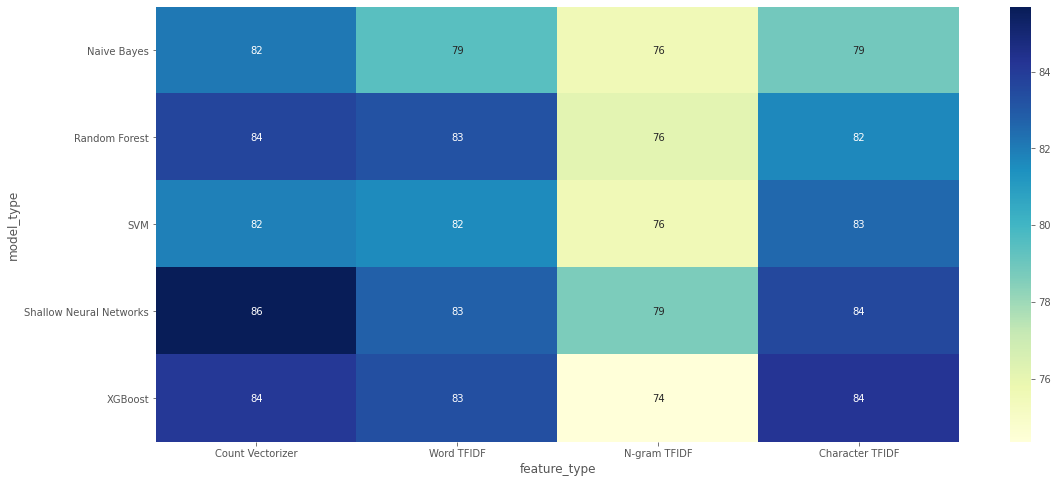

In [44]:
sns.heatmap(match_proportion_valid, annot=True, cmap="YlGnBu")

In [45]:
match_proportion_valid.style.background_gradient(cmap='Blues')

feature_type,Count Vectorizer,Word TFIDF,N-gram TFIDF,Character TFIDF
model_type,,,,
Naive Bayes,82.130966,79.467259,75.582686,78.912320
Random Forest,83.684795,83.240844,76.137625,81.687014
SVM,81.908990,81.576027,75.582686,82.574917
Shallow Neural Networks,85.682575,82.796892,78.690344,83.573807
XGBoost,84.128746,83.351831,74.361820,84.239734


In [46]:
match_proportion_test = summary_test.pivot(index='model_type', columns='feature_type', values = 'match_proportion')
match_proportion_test = match_proportion_test[['Count Vectorizer', 'Word TFIDF', 'N-gram TFIDF', 'Character TFIDF']]
match_proportion_test.head(10)

feature_type,Count Vectorizer,Word TFIDF,N-gram TFIDF,Character TFIDF
model_type,,,,
Naive Bayes,83.302064,82.363977,80.487805,82.551595
Random Forest,82.739212,83.677298,72.045028,83.114447
SVM,83.677298,78.048780,73.733583,80.863039
Shallow Neural Networks,82.739212,78.799250,81.238274,82.176360
XGBoost,84.240150,83.677298,79.362101,84.427767


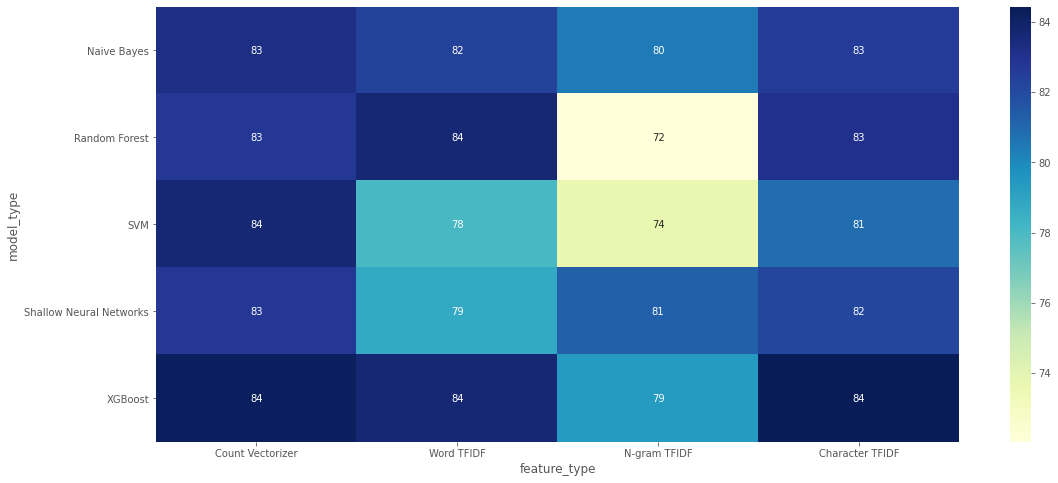

In [47]:
sns.heatmap(match_proportion_test, annot=True, cmap="YlGnBu")

In [48]:
match_proportion_test.style.background_gradient(cmap='Blues')

feature_type,Count Vectorizer,Word TFIDF,N-gram TFIDF,Character TFIDF
model_type,,,,
Naive Bayes,83.302064,82.363977,80.487805,82.551595
Random Forest,82.739212,83.677298,72.045028,83.114447
SVM,83.677298,78.048780,73.733583,80.863039
Shallow Neural Networks,82.739212,78.799250,81.238274,82.176360
XGBoost,84.240150,83.677298,79.362101,84.427767


In [49]:
match_proportion_valid.to_csv(os.getcwd() + '/Model_Output/accuracy_measures_validation.csv')

In [50]:
match_proportion_test.to_csv(os.getcwd() + '/Model_Output/accuracy_measures_test.csv')